In [48]:
import json
import os
import time

import openai
from tqdm import tqdm

In [49]:
MAX_API_RETRY = 10000
REQ_TIME_GAP = 4

os.environ["OPENAI_API_KEY"] = "your-openai-api-key-here"
openai.api_key = os.environ["OPENAI_API_KEY"]

### Positional Bias of the LLM Evaluator
An evaluation template with three placeholders T (Q, R1, R2), is used to query the LLM for eval- uation. For each testing question q, given two re- sponses r1 and r2 from Assistant 1 and Assistant 2, respectively, the researchers populate these re- sponses into the corresponding slots of the evalu- ation template to form a prompt: T (Q = q, R1 = r1, R2 = r2). The prompt is then used to query the LLM in order to obtain the comparison result.

In [4]:
def gen_prompt(ques, ans1, ans2):
    sys_prompt = 'You are a helpful and precise assistant for checking the quality of the answer.'
    prompt_template = "[Question]\n{question}\n\n[The Start of Assistant 1's Answer]\n{answer_1}\n[The End of Assistant 1's Answer]\n\n[The Start of Assistant 2's Answer]\n{answer_2}\n[The End of Assistant 2's Answer]\n\n[System]\n{prompt}\n"
    default_prompt = """We would like to request your feedback on the per- formance of two AI assistants in response to the user question displayed above.
    Please rate the helpfulness, relevance, accuracy, level of details of their responses. Each assistant receives an overall score on a scale of 1 to 10, where a higher score indicates better overall performance.
    Please first output a single line containing only two values indicating the scores for Assistant 1 and 2, respectively.
    The two scores are separated by a space. In the sub- sequent line, please provide a comprehensive explanation of your evaluation, avoiding any potential bias and ensuring that the order in which the responses were presented does not affect your judgment."""
    return sys_prompt, prompt_template.format(question=ques, answer_1=ans1, answer_2=ans2, prompt=default_prompt)

def query_gpt(eval_model, system_prompt, user_prompt):
    for i in range(MAX_API_RETRY):
        try:
            response = openai.ChatCompletion.create(
                model=eval_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt},
                ],
                temperature=1,
                max_tokens=512,
            )
            return response
        except openai.error.RateLimitError:
            print('rate limit')
            time.sleep(30)
        except Exception as e:
            print('error')
    raise RuntimeError(f"Failed after {MAX_API_RETRY} retries.")

def get_eval(ques, ans1, ans2, eval_model):
    system_prompt, user_prompt = gen_prompt(ques, ans1, ans2)
    response = query_gpt(eval_model, system_prompt, user_prompt)
    all_scores = []
    contents = []
    contents_bpc = []
    choice = response["choices"][0]
    content = choice["message"]["content"]
    score1, score2 = parse_score_from_review(content)
    if score1 != -1 and score2 != -1:
        all_scores.append([score1, score2])
        contents.append(content)
    
    return contents, contents_bpc, [score1, score2]

def parse_score_from_review(review):
    try:
        scores = review.split("\n")[0]
        score1 = scores.split(" ")[0].strip()
        score2 = scores.split(" ")[1].strip()
        return [float(score1), float(score2)]
    except:
        return [-1, -1]

def get_json_list(file_path):
    file_path = os.path.expanduser(file_path)
    with open(file_path, "r") as f:
        json_list = []
        for line in f:
            json_list.append(json.loads(line))
        return json_list

In [5]:
def get_results(m1, m2, eval_model):
    question_jsons = get_json_list("question.jsonl")
    answer1_jsons = get_json_list(f"answer/answer_{m1}.jsonl")
    answer2_jsons = get_json_list(f"answer/answer_{m2}.jsonl")
    output = f"review/review_{m1}_{m2}_{eval_model}.json"

    assert len(question_jsons) == len(answer1_jsons) == len(answer2_jsons)

    reviews = []
    total_len = len(question_jsons)
    question_idx_list = list(range(total_len))

    for i in tqdm(question_idx_list):
        assert (
            answer1_jsons[i]["question_id"]
            == question_jsons[i]["question_id"]
            == answer2_jsons[i]["question_id"]
        )

        ques = question_jsons[i]["text"]
        ans1 = answer1_jsons[i]["text"]
        ans2 = answer2_jsons[i]["text"]
        
        reviews.append(get_eval(ques, ans1, ans2, eval_model))
        
        # To avoid the rate limit set by OpenAI
        time.sleep(REQ_TIME_GAP)

    model1_vs_model2 = {
        'win': 0,
        'tie': 0,
        'loss': 0
    }
    with open(f"{output}", "w") as output_review_file:
        for idx, (contents, contents_bpc, [score1, score2]) in enumerate(reviews):
            results = {
                "question_id": question_jsons[idx]["question_id"],
                "question": question_jsons[idx]["text"],
                "review": contents,
                "review_bpc": contents_bpc,
                "score": [score1, score2],
            }
            output_review_file.write(json.dumps(results) + "\n")
            
            if score1 == score2:
                model1_vs_model2['tie'] += 1
                
            elif score1 > score2:
                model1_vs_model2['win'] += 1
            else:
                model1_vs_model2['loss'] += 1

    print(f'Evaluation results (model1_vs_model2):\n{model1_vs_model2}')

The Win Rate of Vicuna-13B significantly fluctuates when positioned as Assistant 1 and Assistant 2.
Conflict Rate refers to the proportion of conflicting results given by the same evaluator when simply changing the position of two models.

### Vicuna-13B v.s. ChatGPT

In [47]:
m1="gpt35"
m2="vicuna-13b"
eval_model="gpt-3.5-turbo-0301"

get_results(m1, m2, eval_model)

100%|██████████| 80/80 [07:37<00:00,  5.72s/it]

Evaluation results (model1_vs_model2):
{'win': 21, 'tie': 1, 'loss': 58}


In [48]:
m1="vicuna-13b"
m2="gpt35"
eval_model="gpt-3.5-turbo-0301"

get_results(m1, m2, eval_model)

100%|██████████| 80/80 [07:31<00:00,  5.65s/it]

Evaluation results (model1_vs_model2):
{'win': 18, 'tie': 1, 'loss': 61}


In [77]:
gpt35_vs_vicuna13b_results = []

with open('review/review_gpt35_vicuna-13b_gpt-3.5-turbo-0301.json', 'r') as file:
    for line in file:
        json_object = json.loads(line)
        gpt35_vs_vicuna13b_results.append(json_object)

vicuna13b_vs_gpt35_results = []

with open('review/review_vicuna-13b_gpt35_gpt-3.5-turbo-0301.json', 'r') as file:
    for line in file:
        json_object = json.loads(line)
        vicuna13b_vs_gpt35_results.append(json_object)

vicuna13b_win_rate_first = 0
vicuna13b_win_rate_second = 0
conflict = 0

for i in range(len(gpt35_vs_vicuna13b_results)):
    vicuna_as_first_winner = False
    vicuna_as_second_winner = False
    if gpt35_vs_vicuna13b_results[i]['score'][0] < gpt35_vs_vicuna13b_results[i]['score'][1]:
        vicuna13b_win_rate_second += 1
        vicuna_as_second_winner = True
    if vicuna13b_vs_gpt35_results[i]['score'][0] > vicuna13b_vs_gpt35_results[i]['score'][1]:
        vicuna13b_win_rate_first += 1
        vicuna_as_first_winner = True
    if vicuna_as_first_winner != vicuna_as_second_winner:
        conflict += 1


print("Vicuna-13B v.s. ChatGPT | Evaluator: ChatGPT")
print(f"Vicuna-13b win rate as assistant 1: {vicuna13b_win_rate_first / 80 * 100}%")
print(f"Vicuna-13b win rate as assistant 2: {vicuna13b_win_rate_second / 80 * 100}%")
print(f"Conflict rate: {conflict}/80 ({conflict / 80 * 100}%)")
    

Vicuna-13B v.s. ChatGPT | Evaluator: ChatGPT
Vicuna-13b win rate as assistant 1: 22.5%
Vicuna-13b win rate as assistant 2: 72.5%
Conflict rate: 56/80 (70.0%)


### Vicuna-13B v.s. Alpaca-13B

In [6]:
m1="alpaca-13b"
m2="vicuna-13b"
eval_model="gpt-3.5-turbo-0301"

get_results(m1, m2, eval_model)

100%|██████████| 80/80 [07:33<00:00,  5.67s/it]

Evaluation results (model1_vs_model2):
{'win': 7, 'tie': 0, 'loss': 73}


In [7]:
m1="vicuna-13b"
m2="alpaca-13b"
eval_model="gpt-3.5-turbo-0301"

get_results(m1, m2, eval_model)

100%|██████████| 80/80 [07:18<00:00,  5.49s/it]

Evaluation results (model1_vs_model2):
{'win': 55, 'tie': 0, 'loss': 25}


In [78]:
alpaca13b_vs_vicuna13b_results = []

with open('review/review_alpaca-13b_vicuna-13b_gpt-3.5-turbo-0301.json', 'r') as file:
    for line in file:
        json_object = json.loads(line)
        alpaca13b_vs_vicuna13b_results.append(json_object)

vicuna13b_vs_alpaca13b_results = []

with open('review/review_vicuna-13b_alpaca-13b_gpt-3.5-turbo-0301.json', 'r') as file:
    for line in file:
        json_object = json.loads(line)
        vicuna13b_vs_alpaca13b_results.append(json_object)

vicuna13b_win_rate_first = 0
vicuna13b_win_rate_second = 0
conflict = 0

for i in range(len(gpt35_vs_vicuna13b_results)):
    vicuna_as_first_winner = False
    vicuna_as_second_winner = False
    if alpaca13b_vs_vicuna13b_results[i]['score'][0] < alpaca13b_vs_vicuna13b_results[i]['score'][1]:
        vicuna13b_win_rate_second += 1
        vicuna_as_second_winner = True
    if vicuna13b_vs_alpaca13b_results[i]['score'][0] > vicuna13b_vs_alpaca13b_results[i]['score'][1]:
        vicuna13b_win_rate_first += 1
        vicuna_as_first_winner = True
    if vicuna_as_first_winner != vicuna_as_second_winner:
        conflict += 1


print("Vicuna-13B v.s. Alpaca-13B | Evaluator: ChatGPT")
print(f"Vicuna-13b win rate as assistant 1: {vicuna13b_win_rate_first / 80 * 100}%")
print(f"Vicuna-13b win rate as assistant 2: {vicuna13b_win_rate_second / 80 * 100}%")
print(f"Conflict rate: {conflict}/80 ({conflict / 80 * 100}%)")
    

Vicuna-13B v.s. Alpaca-13B | Evaluator: ChatGPT
Vicuna-13b win rate as assistant 1: 68.75%
Vicuna-13b win rate as assistant 2: 91.25%
Conflict rate: 26/80 (32.5%)


### Calibrating the Positional Bias using Multiple Evidence Calibration (MEC) and Balanced Position Calibration (BPC)


In [65]:
def gen_prompt(ques, ans1, ans2):
    sys_prompt = 'You are a helpful and precise assistant for checking the quality of the answer.'
    prompt_template = "[Question]\n{question}\n\n[The Start of Assistant 1's Answer]\n{answer_1}\n[The End of Assistant 1's Answer]\n\n[The Start of Assistant 2's Answer]\n{answer_2}\n[The End of Assistant 2's Answer]\n\n[System]\n{prompt}\n"
    default_prompt =  """We would like to request your feedback on the performance of two AI assistants in response to the user question displayed above.
    Please rate the helpfulness, relevance, accuracy, level of details of their responses. 

    Each assistant receives an overall score on a scale of 1 to 10, where a higher score indicates better overall performance.
    Please first provide a comprehensive explanation of your evaluation, avoiding any potential bias and ensuring that the order in which the responses were presented does not affect your judgment. 
    Then, output two lines indicating the scores for Assistant 1 and 2, respectively.

    Output with the following format:
    Evaluation evidence: <your evluation explanation here>
    Score of the Assistant 1: <score>
    Score of the Assistant 2: <score>"""
    return sys_prompt, prompt_template.format(question=ques, answer_1=ans1, answer_2=ans2, prompt=default_prompt)

def query_gpt(eval_model, k, system_prompt, user_prompt):
    for i in range(MAX_API_RETRY):
        try:
            response = openai.ChatCompletion.create(
                model=eval_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt},
                ],
                temperature=1,
                max_tokens=512,
                n=k
            )
            return response
        except openai.error.RateLimitError:
            print('rate limit')
            time.sleep(30)
        except Exception as e:
            print('error')
    raise RuntimeError(f"Failed after {MAX_API_RETRY} retries.")


def get_eval(ques, ans1, ans2, eval_model, k, bpc=1):
    cost = 0
    system_prompt, user_prompt = gen_prompt(ques, ans1, ans2)
    response = query_gpt(eval_model, k, system_prompt, user_prompt)
    all_scores = []
    contents = []
    contents_bpc = []
    for choice in response["choices"]:
        content = choice["message"]["content"]
        score1, score2 = parse_score_from_review(content)
        if score1 == -1 or score2 == -1:
            continue
        all_scores.append([score1, score2])
        contents.append(content)
    
    if bpc == 1:
        system_prompt, user_prompt_bpc = gen_prompt(ques, ans2, ans1)
        response_bpc = query_gpt(eval_model, k, system_prompt, user_prompt)
        for choice in response_bpc["choices"]:
            content = choice["message"]["content"]
            score2, score1 = parse_score_from_review(content)
            if score1 == -1 or score2 == -1:
                continue
            all_scores.append([score1, score2])
            contents_bpc.append(content)
    
    score1 = sum([score[0] for score in all_scores]) / len(all_scores)
    score2 = sum([score[1] for score in all_scores]) / len(all_scores)
    return contents, contents_bpc, [score1, score2]


def parse_score_from_review(review):
    try:
        score1 = review.split("\n")[-2]
        score2 = review.split("\n")[-1]
        score1 = score1.split(":")[-1].strip()
        score2 = score2.split(":")[-1].strip()
        return [float(score1), float(score2)]
    except:
        return [-1, -1]

def get_json_list(file_path):
    file_path = os.path.expanduser(file_path)
    with open(file_path, "r") as f:
        json_list = []
        for line in f:
            json_list.append(json.loads(line))
        return json_list

In [66]:
def get_results(m1, m2, eval_model, bpc, k):
    question_jsons = get_json_list("question.jsonl")
    answer1_jsons = get_json_list(f"answer/answer_{m1}.jsonl")
    answer2_jsons = get_json_list(f"answer/answer_{m2}.jsonl")
    output = f"review/review_{m1}_{m2}_{eval_model}_mec{k}_bpc{bpc}.json"

    assert len(question_jsons) == len(answer1_jsons) == len(answer2_jsons)

    reviews = []
    total_len = len(question_jsons)
    question_idx_list = list(range(total_len))

    for i in tqdm(question_idx_list):
        assert (
            answer1_jsons[i]["question_id"]
            == question_jsons[i]["question_id"]
            == answer2_jsons[i]["question_id"]
        )

        ques = question_jsons[i]["text"]
        ans1 = answer1_jsons[i]["text"]
        ans2 = answer2_jsons[i]["text"]
        
        reviews.append(get_eval(ques, ans1, ans2, eval_model, k, bpc))
        
        # To avoid the rate limit set by OpenAI
        time.sleep(REQ_TIME_GAP)

    model1_vs_model2 = {
        'win': 0,
        'tie': 0,
        'loss': 0
    }
    with open(f"{output}", "w") as output_review_file:
        for idx, (contents, contents_bpc, [score1, score2]) in enumerate(reviews):
            results = {
                "question_id": question_jsons[idx]["question_id"],
                "question": question_jsons[idx]["text"],
                "review": contents,
                "review_bpc": contents_bpc,
                "score": [score1, score2],
            }
            output_review_file.write(json.dumps(results) + "\n")
            
            if score1 == score2:
                model1_vs_model2['tie'] += 1
                
            elif score1 > score2:
                model1_vs_model2['win'] += 1
            else:
                model1_vs_model2['loss'] += 1

    print(f'Evaluation results (model1_vs_model2):\n{model1_vs_model2}')

### Variation of accuracy with different number of evidence k when ChatGPT is used as the evaluator.

In [67]:
m1="gpt35"
m2="vicuna-13b"
eval_model="gpt-3.5-turbo-0301"
bpc=1
k=3

get_results(m1, m2, eval_model, bpc, k)

100%|██████████| 80/80 [12:06<00:00,  9.08s/it]

Evaluation results (model1_vs_model2):
{'win': 35, 'tie': 6, 'loss': 39}


In [68]:
m1="gpt35"
m2="vicuna-13b"
eval_model="gpt-3.5-turbo-0301"
bpc=1
k=1

get_results(m1, m2, eval_model, bpc, k)

100%|██████████| 80/80 [10:45<00:00,  8.07s/it]

Evaluation results (model1_vs_model2):
{'win': 33, 'tie': 21, 'loss': 26}


In [69]:
m1="gpt35"
m2="vicuna-13b"
eval_model="gpt-3.5-turbo-0301"
bpc=1
k=5

get_results(m1, m2, eval_model, bpc, k)

100%|██████████| 80/80 [13:21<00:00, 10.02s/it]

Evaluation results (model1_vs_model2):
{'win': 38, 'tie': 10, 'loss': 32}


In [81]:
def get_MEC_BPC_results(k):
    gpt35_vs_vicuna13b_results = []

    with open(f'review/review_gpt35_vicuna-13b_gpt-3.5-turbo-0301_mec{k}_bpc1.json', 'r') as file:
        for line in file:
            json_object = json.loads(line)
            gpt35_vs_vicuna13b_results.append(json_object)

    human_annotations = []

    with open('review/review_gpt35_vicuna-13b_human.txt', 'r') as file:
        for line in file:
            human_annotations.append(line.strip())

    num_correct = 0
    vicuna13b_win_rate = 0

    for i in range(len(gpt35_vs_vicuna13b_results)):
        gpt35_vs_vicuna13b_winner = ""
        if gpt35_vs_vicuna13b_results[i]['score'][0] < gpt35_vs_vicuna13b_results[i]['score'][1]:
            gpt35_vs_vicuna13b_winner = "VICUNA13B"
        elif gpt35_vs_vicuna13b_results[i]['score'][0] > gpt35_vs_vicuna13b_results[i]['score'][1]:
            gpt35_vs_vicuna13b_winner = "CHATGPT"
        else:
            gpt35_vs_vicuna13b_winner = "TIE"

        if gpt35_vs_vicuna13b_winner == human_annotations[i]:
            num_correct += 1
        if gpt35_vs_vicuna13b_winner == "VICUNA13B":
            vicuna13b_win_rate += 1


    print(f"Vicuna-13B v.s. ChatGPT | Evaluator: ChatGPT | MEC (k={k}) + BPC (k={k})")
    print(f"Vicuna-13b win rate: {vicuna13b_win_rate / 80 * 100}%")
    print(f"Accuracy in terms of closeness with human annotations: {num_correct}/80 ({num_correct / 80 * 100}%)")
    print()
    return num_correct / 80 * 100

In [82]:
accuracy_k_1 = get_MEC_BPC_results(1)
accuracy_k_3 = get_MEC_BPC_results(3)
accuracy_k_5 = get_MEC_BPC_results(5)

Vicuna-13B v.s. ChatGPT | Evaluator: ChatGPT | MEC (k=1) + BPC (k=1)
Vicuna-13b win rate: 32.5%
Accuracy in terms of closeness with human annotations: 37/80 (46.25%)

Vicuna-13B v.s. ChatGPT | Evaluator: ChatGPT | MEC (k=3) + BPC (k=3)
Vicuna-13b win rate: 48.75%
Accuracy in terms of closeness with human annotations: 32/80 (40.0%)

Vicuna-13B v.s. ChatGPT | Evaluator: ChatGPT | MEC (k=5) + BPC (k=5)
Vicuna-13b win rate: 40.0%
Accuracy in terms of closeness with human annotations: 31/80 (38.75%)



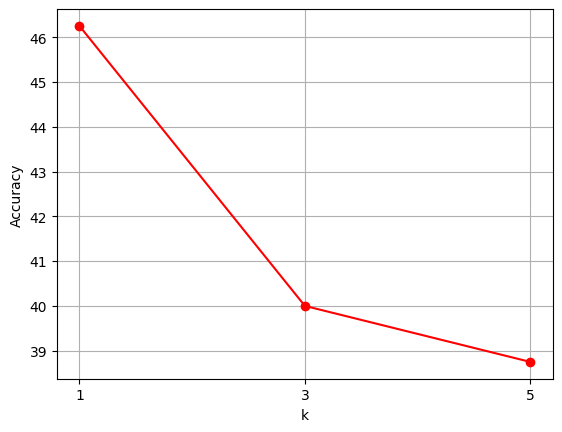

In [84]:
import matplotlib.pyplot as plt

k = [1, 3, 5]
accuracy = [accuracy_k_1, accuracy_k_3, accuracy_k_5]

plt.plot(k, accuracy, 'o-', color='red')
plt.xticks(k)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)